In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.units as u
import pandas as pd
from utils import *

%load_ext autoreload
%autoreload 2

### Read and initial plot of data

In [2]:
dir = "/Users/mac/Desktop/astrostats/jas1101_project/scripts/get_globular_clusters/output"

In [3]:
gc = pd.read_csv(os.path.join(dir, "NGC_104_47Tuc.csv"), skiprows=54, sep=" ")
gc.head()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob
0,-0.197768,-0.588896,4.437221,-3.046831,2.568937,2.304999,-0.435020,20.77880,0.816515,0,0.00000
1,-0.132277,-0.576262,-0.060467,-1.399454,1.140334,1.009628,-0.308144,20.19374,0.838819,0,0.00000
2,-0.130210,-0.584196,25.034540,2.431298,1.950605,1.598516,-0.185372,20.80205,2.071041,0,0.00000
3,-0.134829,-0.422390,4.965001,-1.958991,0.432121,0.295054,-0.275978,18.64288,0.965523,1,0.96083
4,-0.127499,-0.603662,0.654260,-0.609768,0.179726,0.137382,-0.125604,17.40447,1.302572,1,0.00000


In [4]:
gc["r"] = np.hypot(gc.x, gc.y)
gc["pm"] = np.hypot(gc.pmx, gc.pmy)

In [5]:
gc.describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,107806.000000,126380.000000,126380.000000,126380.000000,126380.000000
mean,0.020448,-0.011716,4.551414,-2.277182,0.814111,0.675568,-0.111159,18.850155,0.935921,0.291953,0.189248,0.244169,5.624450
std,0.205895,0.208160,3.258890,2.235275,0.747640,0.661056,0.197171,1.388324,0.246328,0.454663,0.384176,0.163278,3.143767
min,-0.666213,-0.665482,-185.768100,-81.400120,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.099703,-0.122219,3.726735,-2.915028,0.309020,0.250860,-0.225217,18.053233,0.801764,0.000000,0.000000,0.119399,4.726025
50%,0.011500,-0.006981,5.071260,-2.351073,0.573033,0.453512,-0.106138,19.053915,0.906712,0.000000,0.000000,0.191362,5.741681
75%,0.128428,0.105823,5.723011,-1.571697,1.048152,0.830895,-0.003526,19.852253,1.041331,1.000000,0.000000,0.331209,6.408186
max,0.666002,0.666213,107.301200,213.179700,5.227345,5.292846,0.982183,20.999300,4.339368,1.000000,0.998725,0.666647,282.763809


Spatial Distribution

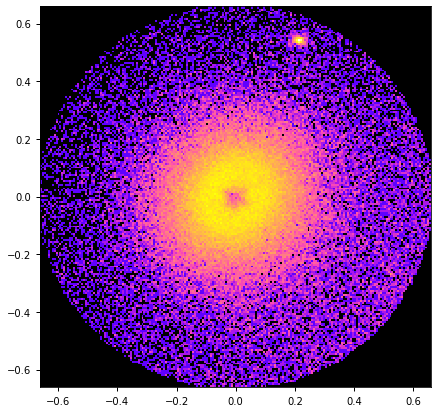

In [6]:
plt.figure(figsize=(7,7))
H, xb, yb, _ = plt.hist2d(gc.x, gc.y, bins=200, range=[[-0.66,0.66],[-0.66,0.66]], norm=LogNorm(), cmap="gnuplot2")

Text(0.5, 0, 'r')

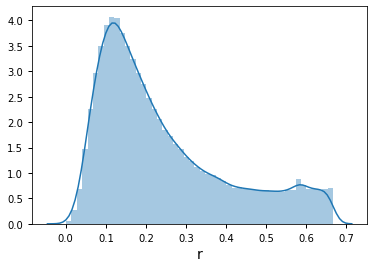

In [7]:
sns.distplot(gc.r)
plt.xlabel("r")

Pruning by scale radius and upper limit of proper motion

In [8]:
gcs = gc[(gc.r<18.3/60) & (gc.pm<15)]

Distribution of proper motion

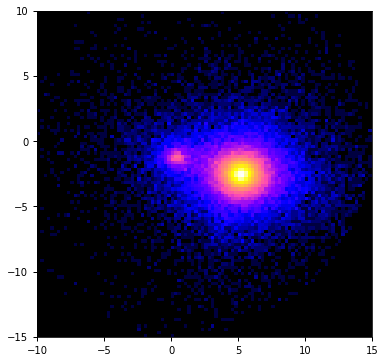

In [9]:
plt.figure(figsize=(6,6))
H, xb, yb, _ = plt.hist2d(gcs.pmx, gcs.pmy, bins=100, range=[[-10,15],[-15,10]], norm=LogNorm(), cmap="gnuplot2")

Text(0.5, 0, 'PM')

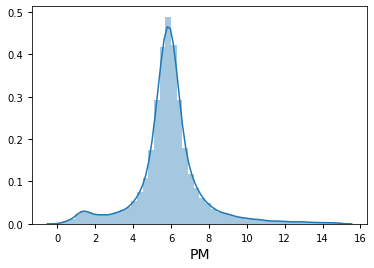

In [11]:
sns.distplot(gcs.pm[gcs.pm<15])
plt.xlabel("PM")

Text(0, 0.5, 'PM')

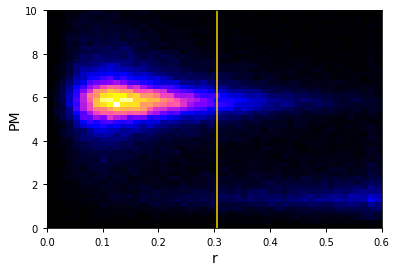

In [12]:
H, xb, yb, _ = plt.hist2d(gc.r, gc.pm, bins=50, range=[[0,0.6],[0,10]], cmap="gnuplot2")
# R scale
plt.axvline(18.3/60, color="gold")
plt.xlabel("r")
plt.ylabel("PM")

### Binning Start From Here

Bin the distribution of pm in radial bins.

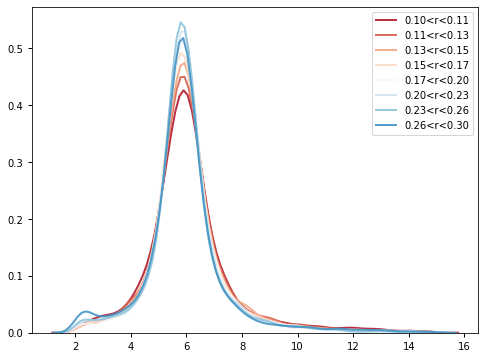

In [13]:
bins = np.logspace(np.log10(0.1), np.log10(0.3), 9)

sns.set_palette("RdBu", len(bins))
r_rbin, z_rbin = profile_binning(gc.r, gc.pm, bins=bins, z_clip=[2,15],
                                 return_bin=False, plot=True)

Acquire all the stars from a particular bin:

In [14]:
z_bins = profile_binning(gcs.r, gcs.pm, bins=bins, z_clip=[2,15],
                         return_bin=True, plot=False)

In [15]:
z_bins["5"]

{'pm': array([6.00306609, 5.63815403, 3.6475262 , ..., 4.71123033, 6.73842532,
        4.08646443]),
 'r': array([0.22197456, 0.20309179, 0.21747407, ..., 0.21703462, 0.22469346,
        0.21869273])}

PM radial profile

Text(0, 0.5, 'PM')

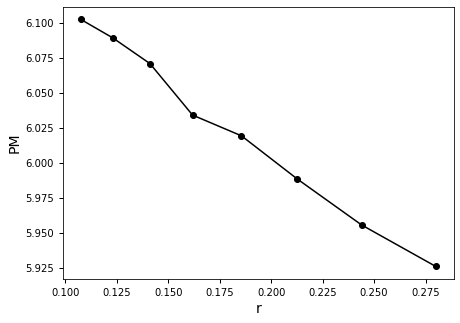

In [18]:
plt.figure(figsize=(7,5))
plt.plot(r_rbin, z_rbin, "k-o")
plt.xlabel("r")
plt.ylabel("PM")

### GMM start from here

Perform GMM decomposition. The best number of gaussians is given by the lowest BIC. One can also specify the number of components by giving values to parameter n_comp in GMM( ).

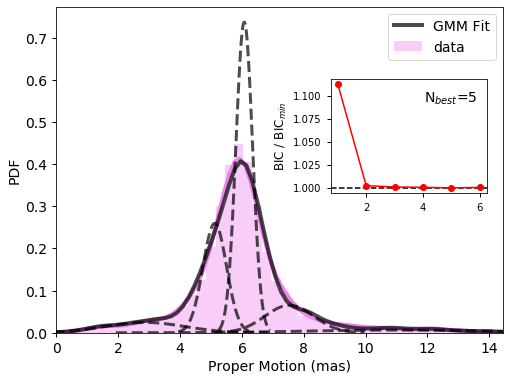

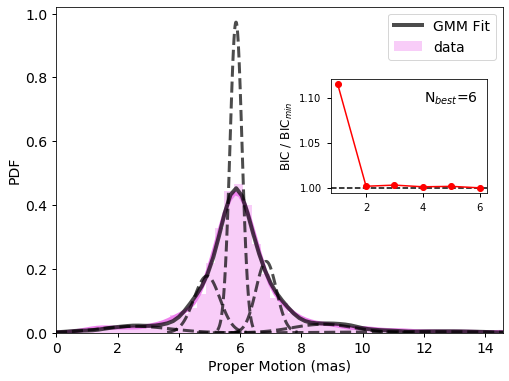

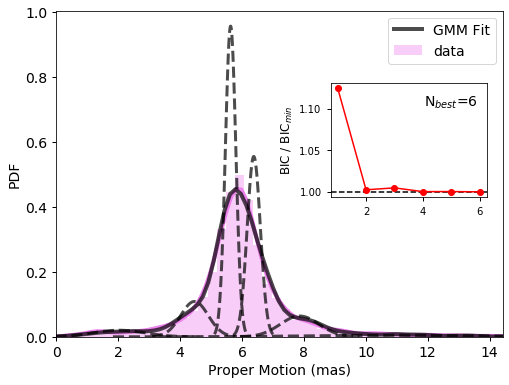

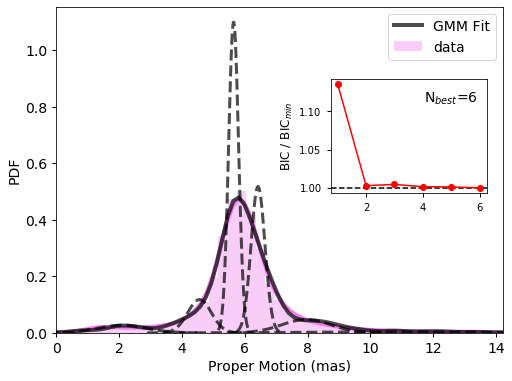

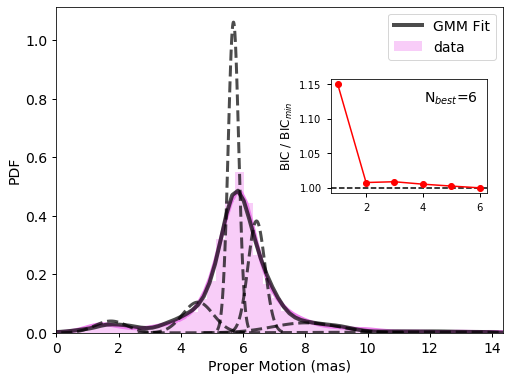

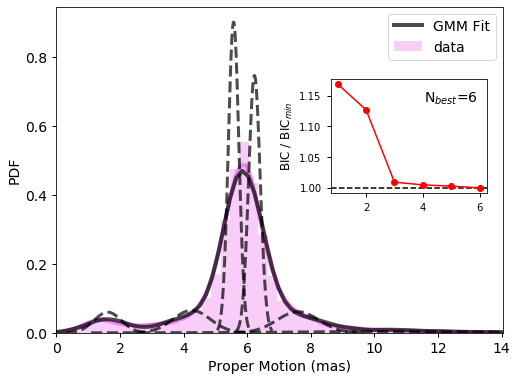

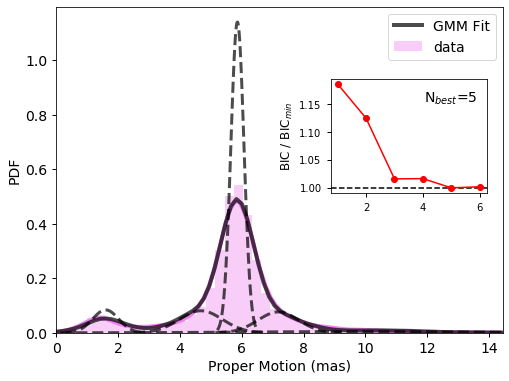

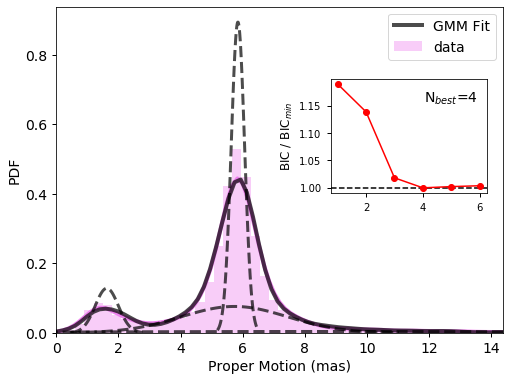

In [32]:
gmm_bins = []
for i in range(len(bins)-1):
    gcb = gcs[(bins[i]<gcs.r)&(gcs.r<bins[i+1])]
    gmm = GMM(gcb.pm, max_n_comp=6, verbose=False)
    gmm_bins.append(gmm)

Probability that a star is giving by the major population. Passing a subsample

In [33]:
prob_main_pop = predict_main_pop(z_bins["5"]["pm"], gmm_bins[5])
prob_main_pop

array([0.99960119, 0.99977439, 0.99174147, ..., 0.9997281 , 0.99709272,
       0.99928008])

Visualize GMM discrimination in each bin:

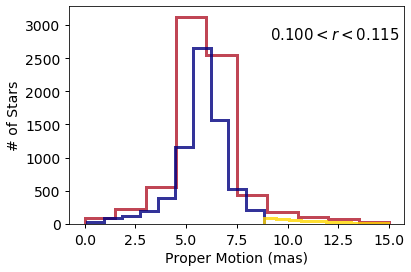

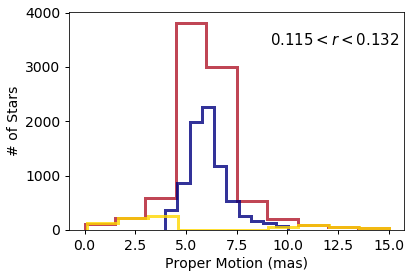

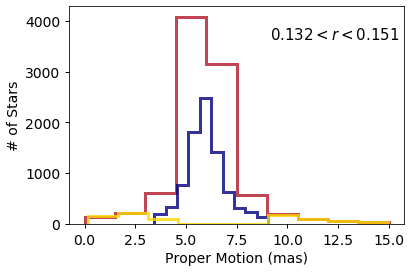

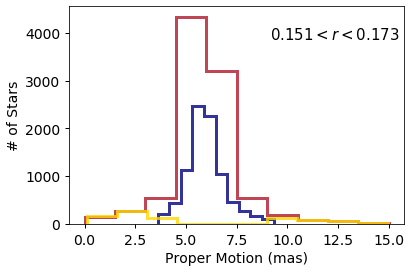

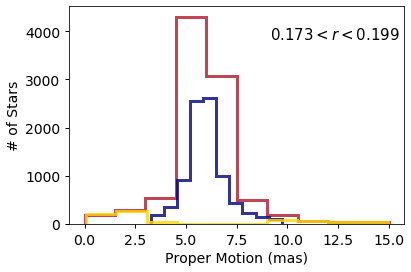

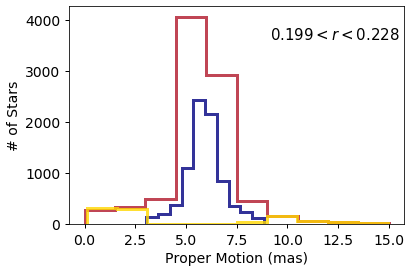

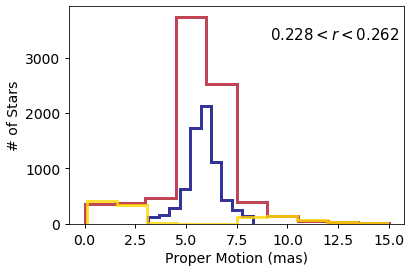

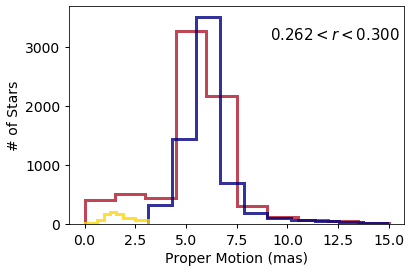

In [44]:
plot_predict_main_pop(gcs, bins, gmm_bins, p_thre=0.8)

Visualize GMM results combining bins:

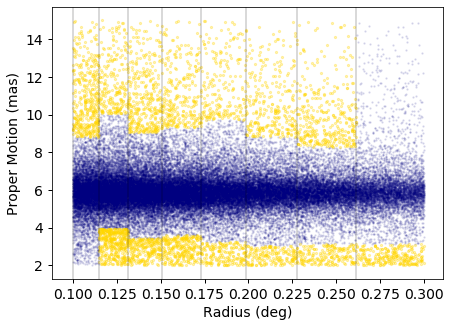

In [40]:
for i in range(len(bins)-1):
    
    r = z_bins[str(i)]["r"]
    pm = z_bins[str(i)]["pm"]
    gmm = gmm_bins[i]
    
    prob_main_pop = predict_main_pop(pm, gmm)
    is_main_pop = prob_main_pop > 0.8
    
    plt.scatter(r[is_main_pop], pm[is_main_pop], color="navy", alpha=0.1, s=2)
    plt.scatter(r[~is_main_pop], pm[~is_main_pop], color="gold", alpha=0.3, s=5)
    plt.axvline(bins[i], color="k", alpha=0.2)
    plt.ylabel("Proper Motion (mas)")
    plt.xlabel("Radius (deg)")
plt.show()